In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [16]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [2]:
import random

In [17]:
def build_dataset(words):
  block_size = 3     
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]  
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(47)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182501, 3]) torch.Size([182501])
torch.Size([22802, 3]) torch.Size([22802])
torch.Size([22843, 3]) torch.Size([22843])


Xtr of the shape (no. of examples, features)

In [ ]:
n_embd = 10         # dimensionality of char embedding vectors
n_hidden = 200      # no. of neurons in hidden layer
block_size = 3

g = torch.Generator().manual_seed(2347483647)

C = torch.randn((vocab_size, n_embd), generator=g)
w1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * 0.3
# not using b1 as it again gets subtracted in bnmeani
# b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0

# batch normalization gain
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

params = [C, w1, b1, w2, b2, bngain, bnbias]
for p in params:
  p.requires_grad = True

In [19]:
sum(p.nelement() for p in params)  # total params

11897

In [ ]:
batch_size = 32
max_steps = 10000

for i in range(max_steps):
  # mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]                         # shape -> (32, 3, 10)
  embcat = emb.view(emb.shape[0], -1) 
  # linear layer 
  hpreact = embcat @ w1 # + b1         hidden layer pre-activation

  # Normalizing hpreact
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  # non-linearity
  h = torch.tanh(hpreact)             # hidden layer
  logits = h @ w2 + b2                # O/P layer
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 5000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  if i % 500 == 0:
    print(f'{i:7d}: {loss.item():.4f}')

print(loss.item())

      0: 3.5817
    500: 2.7809
   1000: 2.3452
   1500: 2.4349
   2000: 2.1705
   2500: 2.4270
   3000: 2.1612
   3500: 2.0056
   4000: 2.2919
   4500: 2.4275
   5000: 2.5552
   5500: 2.3594
   6000: 2.4351
   6500: 1.9831
   7000: 2.3384
   7500: 2.4134
   8000: 2.1125
   8500: 2.1823
   9000: 2.1660
   9500: 2.2043
2.0442795753479004


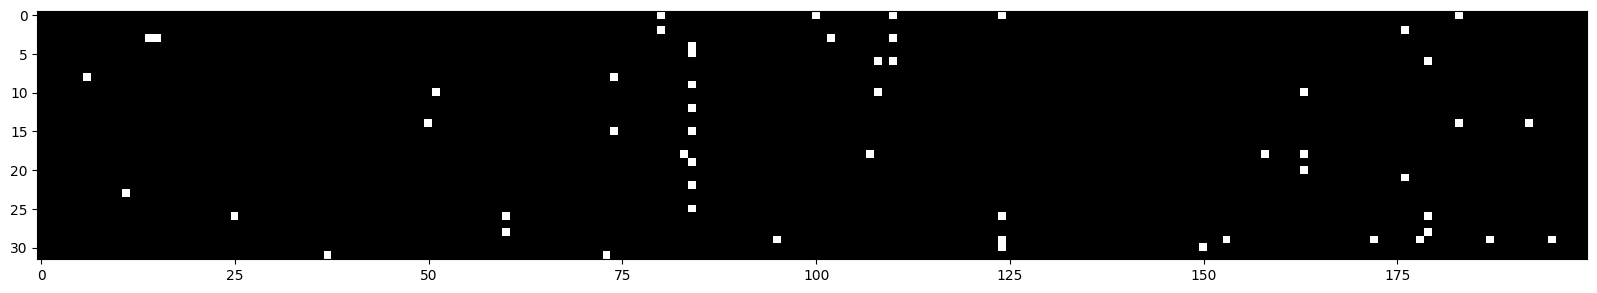

In [71]:
plt.figure(figsize=(20,10))
# white -> true
# because at the head and tail of tanh the values do not change remain -1, 1
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
# calibrate batch norm. at end of training

# do it when forward passing

with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ w1 + b1
  # measure mean and std over the training set
  bnmean = hpreact.mean(0, keepdim=True)      # same as bnmean_running
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad()          # disables gradient tracking
def split_loss(split):
  x, y = {
    'train' : (Xtr, Ytr),
    'val' : (Xdev, Ydev),
    'test' : (Xte, Yte),
  }[split]

  emb = C[x]        # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embd)
  
  hpreact = embcat @ w1 + b1 
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

  h = torch.tanh(hpreact)             # (N, n_hidden)      
  logits = h @ w2 + b2                # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2360100746154785
val 2.23833966255188


In [75]:
# sampling
g = torch.Generator().manual_seed(2347483647 + 10)

for _ in range(10): 
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]    # (1, block_size, n_embd)
    h = torch.tanh(emb.view(1, -1) @ w1 + b1)
    logits = h @ w2 + b2
    probs = F.softmax(logits, dim=1)
    # sampling from the probs to get the index
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

klaex.
ty.
maksi.
sazaud.
arael.
avio.
jolda.
ehndoarilio.
sahainc.
wild.


Optimizations:
- (3.29) this should be our start loss
- but we are starting at around 23 loss, so need to find better initialization
- logits should be very small so we change w2, b2
- our h has many -1 and 1
- hpreact should be around 0 but ours is spread out
- and h values should be more inbetween the curve so that the neurons learn
- if full white column then dead neuron
- so we change w1 and b1

In [27]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [20]:
# Calculating init scale "kaiming init"
# we divide 'w' so that mean and std of y are almost equal to x
# divide by root(no. of input elements)

# looking at kaiming normal for tanh gain = 5/3

In [11]:
(torch.randn(10000) * 0.2).std()

tensor(0.1970)

In [13]:
# for our model
(5/3) / (30**0.5)

0.3042903097250923

tensor(0.0181) tensor(1.0057)
tensor(0.0013) tensor(1.0226)


(array([1.59609105e-04, 2.67453095e-03, 2.71594304e-02, 1.64509536e-01,
        3.89308176e-01, 2.28469649e-01, 4.55576151e-02, 4.59846773e-03,
        2.97649412e-04, 1.72550384e-05]),
 array([-5.35925674, -4.200175  , -3.04109325, -1.88201151, -0.72292976,
         0.43615198,  1.59523373,  2.75431547,  3.91339722,  5.07247896,
         6.23156071]),
 <BarContainer object of 10 artists>)

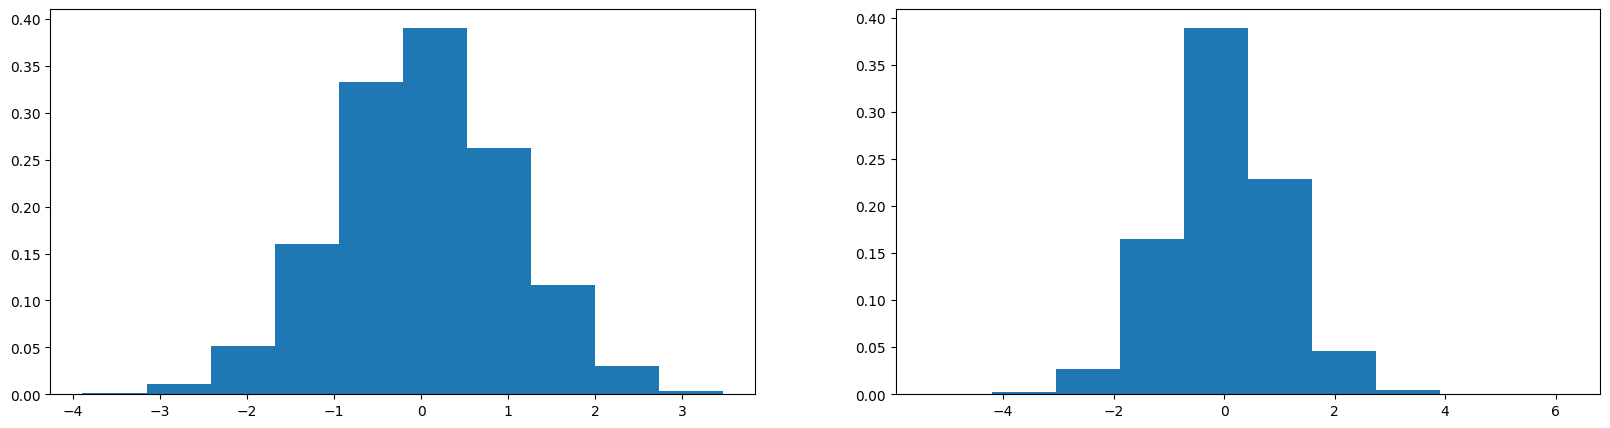

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), density=True)

In [45]:
# Batch Normalization
# we don't want hpreact to be too spread out or small for tanh to work properly
# we are trying to make them gaussian at ( Inilialization )

# examples in batch are coupled by it

In [28]:
print(hpreact.shape)
hpreact.mean(0, keepdim=True).shape
hpreact.std(0, keepdim=True).shape

torch.Size([32, 200])


torch.Size([1, 200])